In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
labels_annotations = pd.read_csv('C:\\DATA\\Skin cancer-dataset\\GroundTruth.csv')
labels_annotations.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
labels_annotations['labels'] = ''
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [4]:
labels_annotations.loc[(labels_annotations['MEL'] != 0.0), 'labels'] = 1
labels_annotations.loc[(labels_annotations['NV'] != 0.0), 'labels'] = 2
labels_annotations.loc[(labels_annotations['BCC'] != 0.0), 'labels'] = 3
labels_annotations.loc[(labels_annotations['AKIEC'] != 0.0), 'labels'] = 4
labels_annotations.loc[(labels_annotations['BKL'] != 0.0), 'labels'] = 5
labels_annotations.loc[(labels_annotations['DF'] != 0.0), 'labels'] = 6
labels_annotations.loc[(labels_annotations['VASC'] != 0.0), 'labels'] = 7

In [5]:
labels = labels_annotations[['image', 'labels']]
labels.head()

,image,labels
0,ISIC_0024306,2
1,ISIC_0024307,2
2,ISIC_0024308,2
3,ISIC_0024309,2
4,ISIC_0024310,1


In [6]:
len(labels)

10015

In [7]:
labels['mask'] = labels['image'] + '_segmentation.png'
labels['image'] = labels['image'] + '.jpg'

In [8]:
labels

,image,labels,mask
0,ISIC_0024306.jpg,2,ISIC_0024306_segmentation.png
1,ISIC_0024307.jpg,2,ISIC_0024307_segmentation.png
2,ISIC_0024308.jpg,2,ISIC_0024308_segmentation.png
3,ISIC_0024309.jpg,2,ISIC_0024309_segmentation.png
4,ISIC_0024310.jpg,1,ISIC_0024310_segmentation.png
...,...,...,...
10010,ISIC_0034316.jpg,1,ISIC_0034316_segmentation.png
10011,ISIC_0034317.jpg,1,ISIC_0034317_segmentation.png
10012,ISIC_0034318.jpg,5,ISIC_0034318_segmentation.png
10013,ISIC_0034319.jpg,2,ISIC_0034319_segmentation.png


In [9]:
val_size = 0.3
val_inds = np.random.choice(len(labels), size = int(val_size * len(labels)), replace = False)
train_inds = [i for i in range(len(labels)) if i not in val_inds]

In [10]:
df_train = labels.iloc[train_inds, :]
df_val = labels.iloc[val_inds, :]

In [11]:
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, mask_dir, transforms_img = None, transforms_mask = None):
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = list(self.df.iloc[:, 0])
        self.masks = list(self.df.iloc[:, 2])
        self.labels = torch.as_tensor(list(self.df.iloc[:, 1]), dtype = torch.long)
        self.transforms_img = transforms_img
        self.transforms_mask = transforms_mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = Image.open(img_path)
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = Image.open(mask_path)
        label = self.labels[idx]
        if self.transforms_img:
            img = self.transforms_img(img)
        if self.transforms_mask:
            mask = self.transforms_mask(mask)
        return img, mask, label

In [12]:
transformations_train = T.Compose([T.Resize((224, 224)), 
                                   T.ColorJitter(brightness = 0.3, hue = 0.2),
                                   T.RandomPosterize(bits = 2, p = 0.5),
                                   T.ToTensor(), 
                                   T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
transformations_val = T.Compose([T.Resize((224, 224)), 
                                 T.ToTensor(),
                                 T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

In [13]:
transform_mask_train = T.Compose([T.Resize((224, 224)), 
                                  T.ToTensor()])
transform_mask_val = T.Compose([T.Resize((224, 224)), 
                                T.ToTensor()])

In [14]:
data_train = SkinCancerDataset(df_train, r'C:\DATA\Skin cancer-dataset\images', r'C:\DATA\Skin cancer-dataset\masks', 
                               transformations_train, transform_mask_train)
data_val = SkinCancerDataset(df_val, r'C:\DATA\Skin cancer-dataset\images', r'C:\DATA\Skin cancer-dataset\masks', 
                               transformations_val, transform_mask_val)

In [15]:
len(data_train), len(data_val)

(7011, 3004)

In [16]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = 8, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size = 8, shuffle = False)

In [17]:
for imgs, msks, labs in train_dataloader:
    print(imgs.shape, imgs.dtype)
    print(msks.shape, msks.dtype)
    print(labs.shape, labs.dtype)
    break

torch.Size([8, 3, 224, 224]) torch.float32
torch.Size([8, 1, 224, 224]) torch.float32
torch.Size([8]) torch.int64


In [18]:
imgs, msks, labs = next(iter(train_dataloader))

In [19]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [20]:
def show_img(img_tensor, title = ''):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    plt.figure(figsize=(18,15))
    plt.imshow(img.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
def show_msk(msk_tensor, title = ''):
    msk = msk_tensor.permute(1, 2, 0).numpy()
    plt.figure(figsize=(18,15))
    plt.imshow(msk.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

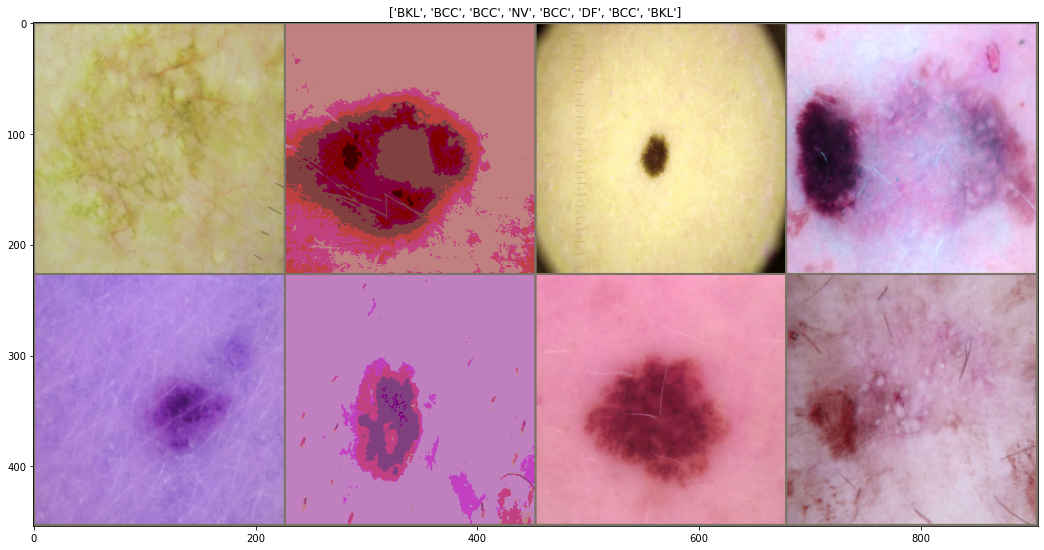

In [21]:
show_img(torchvision.utils.make_grid(imgs, nrow = 4), [class_names[i] for i in labs])

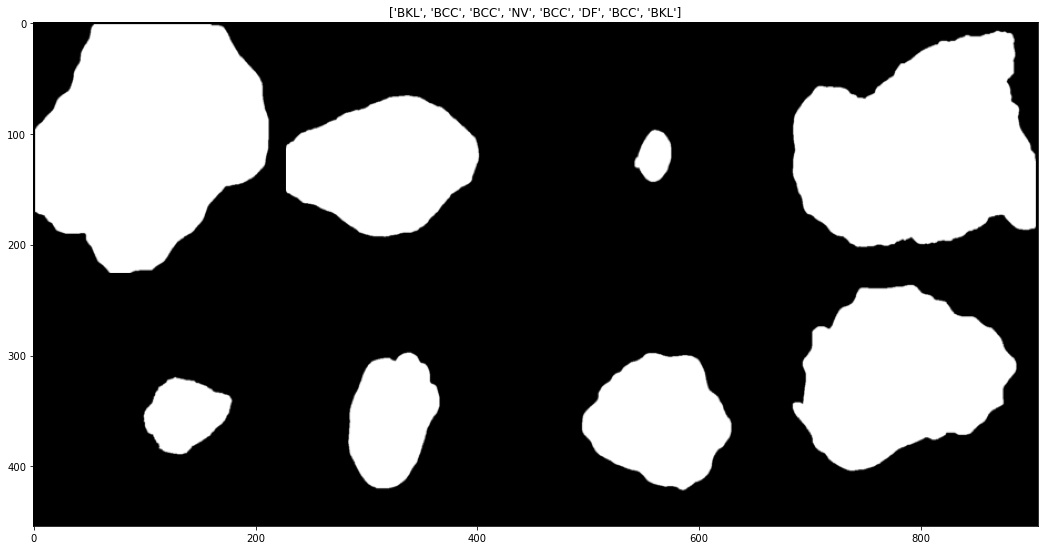

In [22]:
show_msk(torchvision.utils.make_grid(msks, nrow = 4), [class_names[i] for i in labs])

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [25]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained = True)

In [26]:
model.classifier = DeepLabHead(2048, 8)

In [27]:
model = model.to(device)

In [28]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr = 0.001)

In [47]:
def train_model(model, train_loader, loss_func, optimizer, n_epochs):
    
    train_loss = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        
        model.train()
        
        for imgs, msks, _ in tqdm(train_loader):
            optimizer.zero_grad()
            imgs = imgs.to(device)
            msks = msks.to(device)
            output = model(imgs)
            loss = loss_func(output['out'], msks)
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss.item())
                          
        print(f'Epoch {epoch + 1} of {n_epochs}')
        
        # scheduler.step()
        
        train_loss.append(np.mean(ep_train_loss))
        
        print(f"\t train_loss: {train_loss[-1]:.6f}")
        
    return train_loss